<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [93]:
import numpy as np
import pandas as pd, patsy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import grid_search, datasets
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

# Load graph packages
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

***
### Dataset
I've chosen to look at businesses_small_parsed.csv because I think the features are the most interesting... specifically the categories column. My working hypothesis is the frequency of certain business categories (for example Nightlife, Adult Entertainment, etc) make Las Vegas distinct from Phoenix, Surprise, and Waterloo.

In [4]:
tips = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')

In [5]:
checkins = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/yelp_arizona_data/checkins_small_parsed.csv')

In [6]:
reviews = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')

In [7]:
users = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/yelp_arizona_data/users_small_parsed.csv')

In [8]:
business = pd.read_csv('/Users/VanessaG/desktop/DSI-SF-2-vnessified/datasets/yelp_arizona_data/businesses_small_parsed.csv')

In [9]:
business.head(2)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False


In [10]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152832 entries, 0 to 152831
Data columns (total 11 columns):
business_id      152832 non-null object
name             152832 non-null object
review_count     152832 non-null int64
city             152832 non-null object
stars            152832 non-null float64
categories       152832 non-null object
latitude         152832 non-null float64
longitude        152832 non-null float64
neighborhoods    152832 non-null object
variable         152832 non-null object
value            152832 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 12.8+ MB


In [11]:
#just trying an alternate way
business.ix[business.index[(business.T == np.nan).sum() > 1]]

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value


In [12]:
#convert city to binary
#I think it would be cool to also encode the other cities
#but for simplicity sake I'm restricting it to Las Vegas vs not Las Vegas
business['city'] = business['city'].map(lambda x: 0 if x == 'Las Vegas' else 1)

In [13]:
business.city.value_counts()

0    93818
1    59014
Name: city, dtype: int64

In [14]:
business.categories.value_counts()

['Burgers', 'Fast Food', 'Restaurants']                                                                         9522
['Fast Food', 'Restaurants']                                                                                    5752
['Fast Food', 'Sandwiches', 'Restaurants']                                                                      5616
['Burgers', 'Restaurants']                                                                                      4817
['Fast Food', 'Mexican', 'Restaurants']                                                                         4726
['Bars', 'Nightlife', 'Lounges']                                                                                3901
['Breakfast & Brunch', 'American (Traditional)', 'Restaurants']                                                 3595
['Bars', 'Nightlife']                                                                                           3030
['Breakfast & Brunch', 'Restaurants']                           

In [15]:
#creating binary values with get_dummies, which results in slightly different results than using kiefer's way 
stripped = business['categories'].map(lambda x: ''.join([y for y in x if not y in "[]'\""]))
new_cat = stripped.str.get_dummies(', ')

In [16]:
new_cat.head()

,Active Life,Adult Entertainment,Afghan,Airport Lounges,Airports,Amateur Sports Teams,American (New),American (Traditional),Arcades,Art Galleries,...,Vegan,Vegetarian,Venues & Event Spaces,Vintage & Consignment,Weight Loss Centers,Wholesale Stores,Wine & Spirits,Wine Bars,Womens Clothing,Yoga
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#creating binary values - kiefer's way
business['cat_lists'] = business.categories.map(lambda x: eval(x))

In [16]:
unique_categories = []
for catlist in business.cat_lists.values:
    unique_categories.extend(catlist)
    
unique_categories = np.unique(unique_categories)
unique_categories[:10]

array(['Active Life', 'Adult Entertainment', 'Afghan', 'Airport Lounges',
       'Airports', 'Amateur Sports Teams', 'American (New)',
       'American (Traditional)', 'Arcades', 'Art Galleries'], 
      dtype='|S32')

In [17]:
new_cat_2 = pd.DataFrame()

for uc in unique_categories:
    new_cat_2[uc] = business.cat_lists.map(lambda x: 1 if uc in x else 0)

In [78]:
new_cat_2.head()


,active_life,adult_entertainment,afghan,airport_lounges,airports,amateur_sports_teams,american_(new),american_(traditional),arcades,art_galleries,...,"used,_vintage_consignment",vape_shops,vegan,vegetarian,venues_event_spaces,weight_loss_centers,wholesale_stores,wine_bars,women's_clothing,yoga
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
business.categories.value_counts()

['Burgers', 'Fast Food', 'Restaurants']                                                                         9522
['Fast Food', 'Restaurants']                                                                                    5752
['Fast Food', 'Sandwiches', 'Restaurants']                                                                      5616
['Burgers', 'Restaurants']                                                                                      4817
['Fast Food', 'Mexican', 'Restaurants']                                                                         4726
['Bars', 'Nightlife', 'Lounges']                                                                                3901
['Breakfast & Brunch', 'American (Traditional)', 'Restaurants']                                                 3595
['Bars', 'Nightlife']                                                                                           3030
['Breakfast & Brunch', 'Restaurants']                           

In [20]:
#basically using the get_dummies way split on commas without regard to quotations
[c for c in new_cat.columns if c not in new_cat_2.columns]

['Beer',
 'Books',
 'Mags',
 'Music & Video',
 'Used',
 'Vintage & Consignment',
 'Wine & Spirits',
 'Womens Clothing']

In [21]:
#kiefer's way split with regard to quotations which is more appropriate here
[c for c in new_cat_2.columns if c not in new_cat.columns]

['Beer, Wine & Spirits',
 'Books, Mags, Music & Video',
 'Used, Vintage & Consignment',
 "Women's Clothing"]

In [22]:
# # annother approach that was pretty slow
# #convert categories to binary
# def fix_cat(row):
#     categories = eval(row['categories'])
#     for category in categories:
#         row[category] = 1
#     return row
# new_cat = business.apply(fix_cat, axis=1).fillna(0)

In [23]:
new_cat_2.head(2)

,Active Life,Adult Entertainment,Afghan,Airport Lounges,Airports,Amateur Sports Teams,American (New),American (Traditional),Arcades,Art Galleries,...,"Used, Vintage & Consignment",Vape Shops,Vegan,Vegetarian,Venues & Event Spaces,Weight Loss Centers,Wholesale Stores,Wine Bars,Women's Clothing,Yoga
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
new_cat_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152832 entries, 0 to 152831
Columns: 210 entries, Active Life to Yoga
dtypes: int64(210)
memory usage: 244.9 MB


In [25]:
#here I'm just cleaning up column names
new_cat_2.rename(columns=lambda x: x.lower().replace(' & ','_').replace(' ','_'), inplace=True)

In [26]:
new_cat_2.head(2)

,active_life,adult_entertainment,afghan,airport_lounges,airports,amateur_sports_teams,american_(new),american_(traditional),arcades,art_galleries,...,"used,_vintage_consignment",vape_shops,vegan,vegetarian,venues_event_spaces,weight_loss_centers,wholesale_stores,wine_bars,women's_clothing,yoga
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
#need confirmation this all worked!
list(new_cat_2.columns)

['active_life',
 'adult_entertainment',
 'afghan',
 'airport_lounges',
 'airports',
 'amateur_sports_teams',
 'american_(new)',
 'american_(traditional)',
 'arcades',
 'art_galleries',
 'arts_crafts',
 'arts_entertainment',
 'asian_fusion',
 'bagels',
 'bakeries',
 'barbeque',
 'barbers',
 'barre_classes',
 'bars',
 'beauty_spas',
 'beer_bar',
 'beer_gardens',
 'beer,_wine_spirits',
 'books,_mags,_music_video',
 'boot_camps',
 'botanical_gardens',
 'bowling',
 'brasseries',
 'breakfast_brunch',
 'breweries',
 'british',
 'bubble_tea',
 'buffets',
 'burgers',
 'cabaret',
 'cafes',
 'canadian_(new)',
 'candy_stores',
 'caribbean',
 'casinos',
 'caterers',
 'champagne_bars',
 'cheesesteaks',
 'chicken_shop',
 'chicken_wings',
 'chinese',
 'chocolatiers_shops',
 'cinema',
 'cocktail_bars',
 'coffee_tea',
 'comedy_clubs',
 'comfort_food',
 'comic_books',
 'convenience_stores',
 'cooking_classes',
 'country_dance_halls',
 'courthouses',
 'creperies',
 'cuban',
 'cultural_center',
 'cupcakes'

In [54]:
new_cat_2['adult_entertainment'].value_counts()

0    152503
1       329
Name: adult_entertainment, dtype: int64

In [55]:
#whats a good way to visualize these variables?

#### Here I pivoted but decided not to do anything with these columns because I opted for a simpler approach due to time constraints

In [56]:
business.value.value_counts()

False          70687
True           32400
00:00           5560
11:00           3212
casual          2577
10:00           2496
22:00           2439
1.0             1932
average         1892
07:00           1694
2.0             1679
21:00           1631
06:00           1576
02:00           1572
no              1556
full_bar        1470
none            1399
23:00           1397
09:00           1165
free             983
17:00            894
20:00            886
15:00            750
08:00            726
16:00            710
19:00            684
12:00            677
01:00            653
10:30            624
18:00            569
               ...  
15:30             62
23:30             51
18:30             44
16:30             44
4.0               38
02:30             36
paid              31
yes_corkage       24
12:30             24
13:30             21
04:30             20
23:59             13
00:30             12
03:30              6
18plus             6
01:20              6
05:45        

In [57]:
business.variable.value_counts()

open                                           4132
attributes.Accepts Credit Cards                3896
attributes.Price Range                         3843
attributes.Parking.valet                       3427
attributes.Parking.street                      3427
attributes.Parking.validated                   3427
attributes.Parking.garage                      3427
attributes.Parking.lot                         3427
attributes.Good For Groups                     3362
attributes.Outdoor Seating                     3267
attributes.Has TV                              3084
attributes.Alcohol                             3050
attributes.Good for Kids                       2909
attributes.Ambience.trendy                     2873
attributes.Ambience.touristy                   2873
attributes.Ambience.classy                     2873
attributes.Ambience.romantic                   2873
attributes.Ambience.intimate                   2873
attributes.Ambience.casual                     2873
attributes.A

In [58]:
def select_item_or_nan(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x

biz_wide = pd.pivot_table(business, columns=['variable'], values='value',
                            index=['business_id'], aggfunc=select_item_or_nan,
                            fill_value=np.nan)

In [59]:
biz_wide.head()

variable,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
business_id,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,True,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0HGqwlfw3I8nkJyMHxAsQ,True,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0VK5Z1BfUHUYq4PoBYNLw,True,NaN,NaN,full_bar,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0bUDim5OGuv8R0Qqq6J4A,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
-1bOb2izeJBZjHC7NWxiPA,True,NaN,NaN,none,True,False,False,False,False,False,...,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True


In [60]:
biz_wide['attributes.Alcohol'].value_counts()

full_bar         1470
none             1399
beer_and_wine     181
Name: attributes.Alcohol, dtype: int64

In [61]:
biz_wide['hours.Sunday.close'].value_counts()

00:00    488
22:00    302
02:00    189
21:00    173
23:00    171
15:00     92
20:00     89
01:00     82
19:00     76
18:00     76
14:00     56
17:00     51
16:00     42
03:00     41
04:00     36
06:00     34
21:30     23
22:30     20
14:30     19
05:00     14
12:00     14
09:00     11
05:30     10
13:00     10
20:30      9
07:00      7
18:30      7
23:30      6
01:30      6
13:30      5
02:30      5
17:30      5
08:00      3
19:30      3
11:30      2
10:00      2
15:30      2
12:30      2
23:59      2
19:15      1
08:30      1
01:15      1
03:45      1
16:30      1
11:00      1
10:30      1
16:45      1
22:15      1
Name: hours.Sunday.close, dtype: int64

#### Looking at some more straight forward columns

In [62]:
business.columns

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value', u'cat_lists'],
      dtype='object')

In [63]:
business.review_count.isnull().sum()

0

In [64]:
business.review_count.describe()

count    152832.00000
mean        113.35011
std         262.24581
min           3.00000
25%          12.00000
50%          34.00000
75%         101.00000
max        5642.00000
Name: review_count, dtype: float64

In [65]:
business.stars.isnull().sum()

0

In [66]:
business.stars.describe()

count    152832.000000
mean          3.471966
std           0.768355
min           1.000000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: stars, dtype: float64

#### Looking at users & reviews briefly

In [67]:
reviews.head(2)

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 21 columns):
yelping_since          144206 non-null object
compliments.plain      47034 non-null float64
review_count           144206 non-null int64
compliments.cute       13133 non-null float64
compliments.writer     33222 non-null float64
fans                   144206 non-null int64
compliments.note       39872 non-null float64
compliments.hot        31748 non-null float64
compliments.cool       41069 non-null float64
compliments.profile    12368 non-null float64
average_stars          144206 non-null float64
compliments.more       25066 non-null float64
elite                  144206 non-null object
name                   144206 non-null object
user_id                144206 non-null object
votes.cool             144206 non-null int64
compliments.list       7180 non-null float64
votes.funny            144206 non-null int64
compliments.photos     18759 non-null float64
compliments.funny  

#### Plan
Ideally I'd like to merge some of the columns from users & reviews (for example users['review_count'] with the idea being the Las Vegas user's review counts are higher than users in the other cities) with the business dataset but since I'm short on time now I'll look at review_count & stars in the business dataset. I'll try out KNN and Logistic Regression.

You may use any classification algorithm you deem appropriate, or even multiple models. You should:
Build at least one model predicting Las Vegas vs. the other cities.
Validate your model(s).
Interpret and visualize, in some way, the results.
Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [69]:
business.columns

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value', u'cat_lists'],
      dtype='object')

In [70]:
biz_subset = business[['city', 'review_count', 'stars']]

In [71]:
business.city.value_counts()

0    93818
1    59014
Name: city, dtype: int64

In [72]:
#not sure it makes sense to do this
biz_subset.corr()

,city,review_count,stars
city,1.000000,-0.096229,-0.004952
review_count,-0.096229,1.000000,0.153375
stars,-0.004952,0.153375,1.000000


#### Performing stratified cross-validation on a KNN classifier and logisitic regression

In [73]:
y = business.city.values
X = business[['review_count','stars']]

In [74]:
y.shape

(152832,)

In [75]:
X.shape

(152832, 2)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [77]:
params = {
    'n_neighbors':range(1,101),
    'weights':['uniform','distance']
}

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn, params, cv=5, verbose=1, n_jobs=4)
knn_gs.fit(X_train, y_train)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  2.6min finished


{'n_neighbors': 80, 'weights': 'distance'}


In [79]:
print best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=80, p=2,
           weights='distance')


In [80]:
cross_val_score(best_knn, X, y, cv=5)

array([ 0.74380868,  0.74024275,  0.74783263,  0.74638487,  0.74382464])

In [81]:
# I'd like to use all the category variables for logistic regression, regularization, lasso

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [17]:
reviews.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
reviews.shape

(322398, 108)

In [19]:
reviews_samp = reviews.sample(frac=0.1)

In [20]:
reviews_samp.shape

(32240, 108)

In [21]:
reviews_samp.head(2)

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
67333,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
samp_service = reviews_samp.filter(like='service')
samp_service[['user_id', 'review_id', '10 minutes', '15 minutes', '20 minutes', '30 minutes', 'friendly staff', 'wait staff']] =\
reviews_samp[['user_id','review_id', '10 minutes', '15 minutes', '20 minutes', '30 minutes', 'friendly staff', 'wait staff']]
samp_service.head()

,bottle service,customer service,food service,good service,great service,service excellent,service food,service friendly,service good,service great,user_id,review_id,10 minutes,15 minutes,20 minutes,30 minutes,friendly staff,wait staff
67333,0,0,0,0,0,0,0,0,0,0,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,0,0,0,0,0
43945,0,0,0,0,0,0,0,0,0,0,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,0,0,0,0,0
51301,0,0,0,0,0,0,0,0,0,0,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,0,0,0,0,0
265559,0,0,0,0,0,0,0,0,0,0,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,0,0,0,0,0
27415,0,0,0,0,0,0,0,0,0,0,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,0,0,0,0,0


In [23]:
# list(reviews)

In [24]:
base_cols = reviews_samp.ix[:,0:8]

In [25]:
samp_service.columns

Index([u'bottle service', u'customer service', u'food service',
       u'good service', u'great service', u'service excellent',
       u'service food', u'service friendly', u'service good', u'service great',
       u'user_id', u'review_id', u'10 minutes', u'15 minutes', u'20 minutes',
       u'30 minutes', u'friendly staff', u'wait staff'],
      dtype='object')

In [26]:
base_cols.review_id

67333     b0NrDm2j6NdLJ_b3cKowHQ
43945     H3z4K8Nc4SBMhB2DJfdw6g
51301     63zg53hmBEsUkH96t44eIA
265559    Ig56c8TpP4I5yE020919gw
27415     0bNHu9s7dDritGUQWdUPHw
303502    FA3T9MjUH1L5AcQaMh70qA
122806    TJZt1FyrL_qy17LIHx2rMA
53805     OvozyThlcA3K6sljosEYHQ
299391    UltQr9h30qGSmipQieegaQ
93605     yvn5M8rbqNZTuoCEAE5DaQ
190109    GptndP3T5L4gyIhDErYwuQ
95043     19YCn2VhnNkAxTgggDIqlg
208479    F3Z4xrMZs750CZuy3rMwKg
17980     2nxJt5yJQmHkd8aM0YILAw
52464     1jVrwixIaGFuCiTupT0XSw
286308    rWXrZd0dCVcOBwImc-3kCQ
1289      f-wE25pVUDiOxVCayauGJQ
2302      oT8hYxI63JpqzyFVKJzFjw
189456    QtJvQ82iHZAOb9stF-L1lA
15599     H1Kil0FU9MU-QwKaskjbrA
141309    o3VsjakbV6z1YTorVXLXVg
94393     daQiPOcfqZz1LxpI9z5yFQ
254069    endp4u52TmiVB7iIvKfN_A
311338    StawwhrnXVdBBi-tOEIwEQ
281751    EolOrYyQ7hu1p5VsZZMPiA
137663    M1hFiUlzS1_FALv-8Vaczw
297436    VYU2ILEXt-L-fYMRJhR4yw
132379    jt-N9RaNCpr1DK_dkP8w_Q
131703    ZKWnhw_X0KUzd1QJkC6wOg
253901    18WKys6HmU4vVxUdc57oAg
          

In [27]:
samp_service = pd.merge(samp_service, base_cols, on=['user_id','review_id'], how='left')

In [28]:
base_cols.shape

(32240, 8)

In [29]:
base_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32240 entries, 67333 to 125374
Data columns (total 8 columns):
user_id         32240 non-null object
review_id       32240 non-null object
votes.cool      32240 non-null int64
business_id     32240 non-null object
votes.funny     32240 non-null int64
stars           32240 non-null int64
date            32240 non-null object
votes.useful    32240 non-null int64
dtypes: int64(4), object(4)
memory usage: 2.2+ MB


In [30]:
base_cols.user_id.values

array(['4GckQhYDZ83h9hxj4401Og', 'ffZqLOuw0tcri94ovl93tw',
       'BeIGAcknzQTJgGSg8Anjbw', ..., 'zXIJbUzcmeLajzoatOTp0w',
       'lZ8QNKiDp7dfI3L_nGeLKg', 'uTigTfhQ_kKXkMXMYz7S7g'], dtype=object)

In [31]:
len(np.intersect1d(base_cols.user_id.unique(), samp_service.user_id.unique()))

25199

In [32]:
samp_service.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32240 entries, 0 to 32239
Data columns (total 24 columns):
bottle service       32240 non-null int64
customer service     32240 non-null int64
food service         32240 non-null int64
good service         32240 non-null int64
great service        32240 non-null int64
service excellent    32240 non-null int64
service food         32240 non-null int64
service friendly     32240 non-null int64
service good         32240 non-null int64
service great        32240 non-null int64
user_id              32240 non-null object
review_id            32240 non-null object
10 minutes           32240 non-null int64
15 minutes           32240 non-null int64
20 minutes           32240 non-null int64
30 minutes           32240 non-null int64
friendly staff       32240 non-null int64
wait staff           32240 non-null int64
votes.cool           32240 non-null int64
business_id          32240 non-null object
votes.funny          32240 non-null int64
stars 

In [33]:
samp_service.shape

(32240, 24)

In [34]:
not_service_cols = [x for x in reviews_samp.columns if x not in samp_service]

In [35]:
samp_not_service_mask = reviews_samp[not_service_cols]

In [36]:
samp_not_service_mask[['user_id', 'review_id']] = reviews_samp[['user_id', 'review_id']].copy()

/Users/VanessaG/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
samp_not_service = pd.merge(samp_not_service_mask, base_cols, on=['user_id','review_id'], how='left')

In [38]:
samp_not_service.shape

(32240, 92)

In [39]:
samp_not_service['user_id'].shape, reviews_samp['user_id'].shape

((32240,), (32240,))

In [40]:
samp_not_service.head()

,bar food,beer selection,best ve,bloody mary,chicken waffles,dance floor,decided try,definitely come,definitely recommend,didn want,...,ve seen,ve tried,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful
0,0,0,0,0,0,0,0,0,0,0,...,0,0,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0


In [41]:
samp_service.head()

,bottle service,customer service,food service,good service,great service,service excellent,service food,service friendly,service good,service great,...,20 minutes,30 minutes,friendly staff,wait staff,votes.cool,business_id,votes.funny,stars,date,votes.useful
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0


In [42]:
samp_service.columns

Index([u'bottle service', u'customer service', u'food service',
       u'good service', u'great service', u'service excellent',
       u'service food', u'service friendly', u'service good', u'service great',
       u'user_id', u'review_id', u'10 minutes', u'15 minutes', u'20 minutes',
       u'30 minutes', u'friendly staff', u'wait staff', u'votes.cool',
       u'business_id', u'votes.funny', u'stars', u'date', u'votes.useful'],
      dtype='object')

In [43]:
# create a variable with a list of service related columns
service_columns = [c for c in samp_service.columns if 'service' in c or 'friendly' in c]
service_columns
# check out the values in service related columns
for column in samp_service.columns:
    if 'service' in column or 'friendly' in column:
        print '%s mentions: ' %column
        print reviews_samp[column].value_counts()
        print
        
# create a new column that sums mentions of service related stuff
reviews_samp['service_related_reviews'] = reviews_samp[service_columns].apply(np.sum, axis=1)
# rename :P
reviews_samp.rename(columns={'service_related_reviews':'service_related_mentions'}, inplace=True)
# check out the values
reviews_samp.service_related_mentions.value_counts()
# create a new column that is binary based on service related mentions
reviews_samp['service_related_binary'] = reviews_samp.service_related_mentions.map(lambda x: 1 if x > 0 else 0)

bottle service mentions: 
0    31951
1      230
2       43
3       10
4        4
7        1
5        1
Name: bottle service, dtype: int64

customer service mentions: 
0    31368
1      800
2       65
3        6
5        1
Name: customer service, dtype: int64

food service mentions: 
0    31689
1      538
2       11
3        2
Name: food service, dtype: int64

good service mentions: 
0    31636
1      596
2        7
3        1
Name: good service, dtype: int64

great service mentions: 
0    31345
1      885
2       10
Name: great service, dtype: int64

service excellent mentions: 
0    31957
1      280
2        3
Name: service excellent, dtype: int64

service food mentions: 
0    31918
1      321
2        1
Name: service food, dtype: int64

service friendly mentions: 
0    31965
1      275
Name: service friendly, dtype: int64

service good mentions: 
0    31647
1      587
2        6
Name: service good, dtype: int64

service great mentions: 
0    31389
1      843
2        8
Name: service 

In [44]:
reviews_samp.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,service_related_mentions,service_related_binary
67333,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51301,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265559,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27415,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
reviews_samp.service_related_mentions.value_counts()

0    27096
1     4298
2      751
3       77
4       15
7        1
6        1
5        1
Name: service_related_mentions, dtype: int64

In [52]:
non_service_columns = [c for c in reviews_samp.columns if c not in service_columns and c not in reviews_samp.columns[:12] and 'service' not in c]

In [53]:
non_service_columns

['bar food',
 'beer selection',
 'best ve',
 'bloody mary',
 'chicken waffles',
 'dance floor',
 'decided try',
 'definitely come',
 'definitely recommend',
 'didn want',
 'don know',
 'don like',
 'don think',
 'don want',
 'eggs benedict',
 'fast food',
 'feel like',
 'felt like',
 'fish chips',
 'food amazing',
 'food came',
 'food delicious',
 'food good',
 'food great',
 'food just',
 'french fries',
 'french toast',
 'friday night',
 'fried chicken',
 'good food',
 'good place',
 'good thing',
 'good time',
 'great atmosphere',
 'great experience',
 'great food',
 'great place',
 'great time',
 'happy hour',
 'hash browns',
 'highly recommend',
 'hip hop',
 'ice cream',
 'just like',
 'just ok',
 'just right',
 'las vegas',
 'late night',
 'like place',
 'little bit',
 'long time',
 'looked like',
 'looks like',
 'love place',
 'mac cheese',
 'make sure',
 'mashed potatoes',
 'medium rare',
 'minutes later',
 'new york',
 'onion rings',
 'place good',
 'place great',
 'place just

In [60]:
reviews_samp['non_service_related_reviews'] = reviews_samp[non_service_columns].apply(np.sum, axis=1)

In [62]:
reviews_samp.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,service_related_mentions,service_related_binary,non_service_related_reviews
67333,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0,0,0,...,0,0,0,0,0,0,0,0,0,3
51301,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0,0,0,...,0,0,0,0,0,0,0,0,0,3
265559,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27415,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [64]:
reviews_samp['service_related_reviews'] =\
(reviews_samp.service_related_mentions - reviews_samp.non_service_related_reviews)

In [67]:
reviews_samp.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,tasted like,time vegas,try place,ve seen,ve tried,wait staff,service_related_mentions,service_related_binary,non_service_related_reviews,service_related_reviews
67333,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0,0,0,...,0,0,0,0,0,0,0,0,3,-3
51301,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0,0,0,...,0,0,0,0,0,0,0,0,3,-3
265559,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27415,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0,0,0,...,0,0,0,0,0,0,0,0,1,-1


In [70]:
reviews_samp['service_related_reviews'] = reviews_samp['service_related_reviews'].map(lambda x: 1 if x > 0 else 0)

In [71]:
reviews_samp.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,tasted like,time vegas,try place,ve seen,ve tried,wait staff,service_related_mentions,service_related_binary,non_service_related_reviews,service_related_reviews
67333,4GckQhYDZ83h9hxj4401Og,b0NrDm2j6NdLJ_b3cKowHQ,0,DJlb6DLzT1yK5ipnL2I1dA,1,2,2014-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,ffZqLOuw0tcri94ovl93tw,H3z4K8Nc4SBMhB2DJfdw6g,0,co0vxQ8ecXiBy2sGDeHi8A,0,5,2013-10-08,0,0,0,...,0,0,0,0,0,0,0,0,3,0
51301,BeIGAcknzQTJgGSg8Anjbw,63zg53hmBEsUkH96t44eIA,0,4bEjOyTaDG24SY5TxsaUNQ,0,5,2011-07-04,0,0,0,...,0,0,0,0,0,0,0,0,3,0
265559,iWiEGZjpXknR9BjxcCuQbA,Ig56c8TpP4I5yE020919gw,0,4X_XAOeMw7AFkYhg3NINJA,0,2,2015-12-17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27415,oAmecNiFMxhwYl8uBk69Zg,0bNHu9s7dDritGUQWdUPHw,0,jf67Z1pnwElRSXllpQHiJg,0,4,2011-06-29,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
reviews_samp.service_related_reviews.value_counts()

0    30311
1     1929
Name: service_related_reviews, dtype: int64

In [80]:
reviews_samp = reviews_samp[['stars', 'service_related_mentions',
                             'non_service_related_reviews', 'service_related_reviews']]

In [90]:
formula = 'service_related_reviews ~ stars - 1'
print formula
y, X = patsy.dmatrices(formula, data=reviews_samp, return_type='dataframe')
y = y.values.ravel()

service_related_reviews ~ stars - 1


X-train shape:  (25792, 1) 
X-test shape: (6448, 1)
y-train shape:  (25792,) 
y-test shape: (6448,)

Baseline Accuracy:  0.0598325062035

Model Score:  0.940136476427



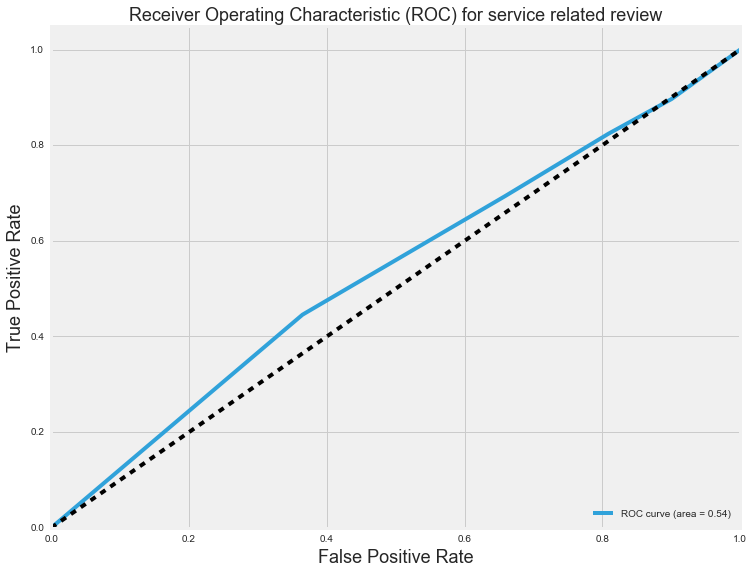

,variable,score
0,stars,0.004376


In [94]:
from sklearn.metrics import roc_curve, auc

def logreg_calculator(predictors, target, title='Your Prediction'): # df, target_name='name'
    
    ### Train-Test-Split
    Xtrain, Xtest, ytrain, ytest = train_test_split(predictors, target, test_size=0.2, stratify=target)
    print 'X-train shape: ', Xtrain.shape, '\nX-test shape:', Xtest.shape
    print 'y-train shape: ', ytrain.shape, '\ny-test shape:', ytest.shape
    print
    
    ### Initiate LogisticRegressionCV
    logreg = LogisticRegressionCV(cv=5)
    
    # Fit the LogisticRegression model
    model = logreg.fit(Xtrain, ytrain)
    
    # Predict Probability of model
    probabilit_y = model.predict_proba(Xtest)
    
    # Score the model
    score = model.score(Xtest, ytest)
    print 'Baseline Accuracy: ', np.mean(target)
    print
    print 'Model Score: ', score
    print
    
    ### Plot the ROC Curve
    # Blank sets for storing confusion matrix metrics here
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()
    # Assigning the 1st offsets to FPR / TPR from the 2nd set of probabiliies from probabilit_y
    FPR[1], TPR[1], _ = roc_curve(ytest, probabilit_y[:, 1])
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    # 1. Initiate a blank figure
    plt.figure(figsize=[11,9])
    
    # 2. Plot false positive and true positive rates (returned from roc_curve function)
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    
    # 3. Plotting a dotted line diagonally, representing the .5
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver Operating Characteristic (ROC) for %s' %title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
    ### Print out the most important variables for predicting your target from logistic regression
    coefs = pd.DataFrame(zip(predictors, model.coef_[0]))
    coefs.rename(columns={0:'variable',1:'score'}, inplace=True)
    
    # iloc variable rows, which are at the very bottom of this df
    # this is going to be dependent upon the number of variables in the df used as predictors
    return coefs.iloc[-14:,:] 
#     below returns an error saying "arrays must all be same length"
#     Im guessing because patsy eliminates the non-numeric columns when it creates the variables matrix
#     coefs = pd.DataFrame({'coef':model.coef_[0], 'abs_coef':np.abs(model.coef_[0]),
#                       'variable':[col for col in df.columns if col != '%s' %target_name]})
#     coefs.sort_values('abs_coef', ascending=False, inplace=True)
#     return coefs
logreg_calculator(X, y, title='service related review') # df = business, target_name='city', 


1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?